In [43]:
# library and module imports for data retrieval and munging
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# some ML (scikit & xgboost) library imports for modelling
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import (train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve)
import sklearn.metrics as metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, SGDClassifier)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
WALKING_GROUPED_FEATURES    = "syn21678699"
MATCHED_DEMOGRAPHICS        = "syn21614563"
ALL_DEMOGRAPHICS            = "syn21602828"
PREVIOUS_ASSAY_DEMOGRAPHICS = "syn8381056"

syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [156]:
#### get data ####
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES)
matched_demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS)
all_demographic = query.get_file_entity(syn, ALL_DEMOGRAPHICS)



### filter unused columns ###
data = data[[feat for feat in data.columns 
            if ("window" not in feat) 
            and ("steps" not in feat) 
            and ("avg_number_of_strides" not in feat) 
            and ("amax" not in feat)
            and ("x_speed_of_gait" not in feat)
            and ("y_speed_of_gait" not in feat)
            and ("z_speed_of_gait" not in feat)]]


# #### filter datasets ####
# active_data = data[(data["test_type"] == "walking") & 
#             (data["age"] > 0) & 
#             (data["table_version"] != "MPOWER_PASSIVE") &
#             (data["class"] != "MS")]
# active_data = pd.merge(
#     matched_demographic[["healthCode"]], 
#     active_data, 
#     on = "healthCode", 
#     how = "inner")



# #### filter datasets ####
# passive_data = data[(data["test_type"] == "walking") & 
#             (data["age"] > 0) & 
#             (data["table_version"] == "MPOWER_PASSIVE") &
#             (data["class"] != "MS")]
# passive_data = pd.merge(
#     all_demographic[["healthCode"]], 
#     passive_data, 
#     on = "healthCode", 
#     how = "inner")



# #### cols of choice ####
# metadata_cols = ["test_type", "phoneInfo", "age", 
#                  "gender", "table_version", 
#                  "nrecords", "class"]
# feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

In [157]:
data.columns

Index(['age', 'class', 'gender', 'healthCode', 'iqr_AA_avg_step_duration',
       'iqr_AA_avg_stride_duration', 'iqr_AA_cadence',
       'iqr_AA_energy_freeze_index', 'iqr_AA_loco_freeze_index',
       'iqr_AA_sd_step_duration',
       ...
       'std_z_cadence', 'std_z_energy_freeze_index', 'std_z_loco_freeze_index',
       'std_z_sd_step_duration', 'std_z_sd_stride_duration',
       'std_z_step_regularity', 'std_z_stride_regularity', 'std_z_symmetry',
       'table_version', 'test_type'],
      dtype='object', length=134)

In [149]:
healthCode_not_in_training = pd.merge(active_data[feat_cols], passive_data[feat_cols], on = "healthCode", how = "inner").healthCode
sufficient_healthCode = passive_data["healthCode"][passive_data.isnull().mean(axis = 1) < 0.2]

In [145]:
test_passive_set = passive_data[(~passive_data["healthCode"].isin(remove_healthCode))
                               & (passive_data["healthCode"].isin(sufficient_healthCode))].reset_index(drop = True)

In [146]:
def visualize_feature_in_classes(data, f_cols):
    for cols in f_cols:
        try:
            plt.figure(figsize = (9,5))
            for class_ in data["class"].unique()[::-1]:
                sns.distplot(data[cols][data["class"] == class_].dropna(), 
                             label = class_)
            plt.legend()
            plt.show()
        except TypeError:
            continue

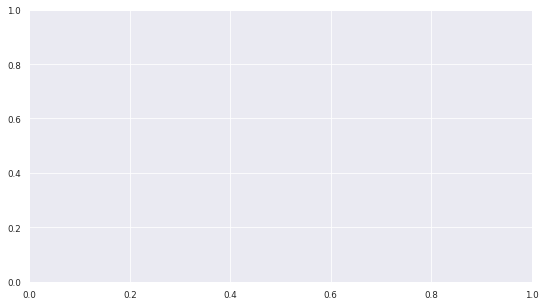

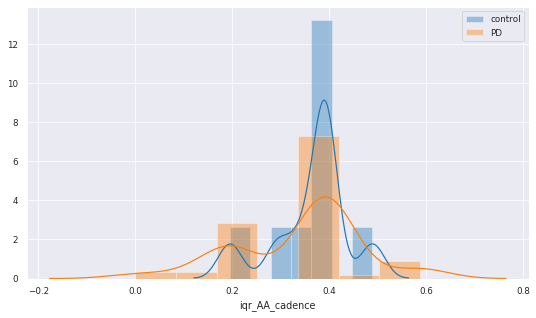

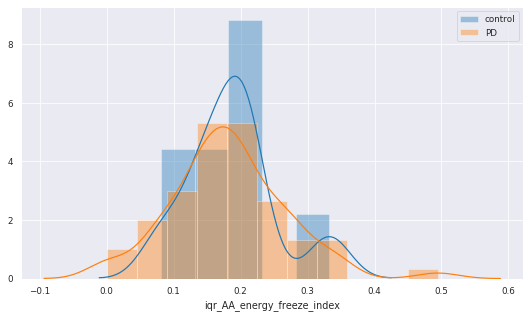

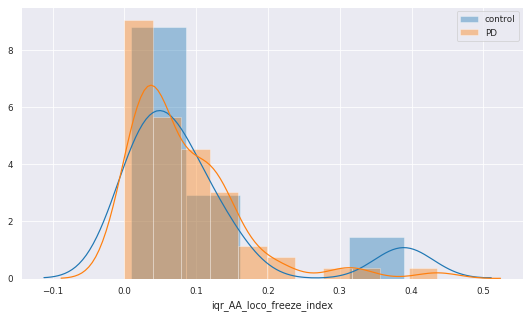

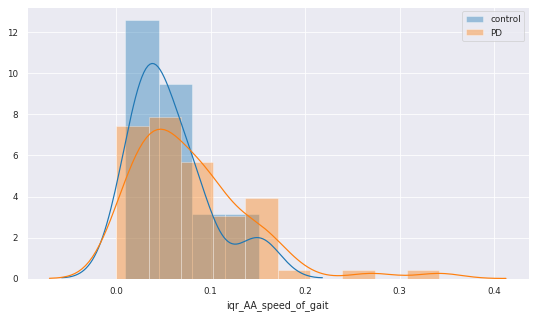

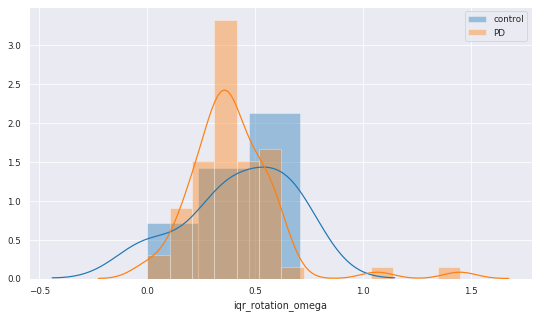

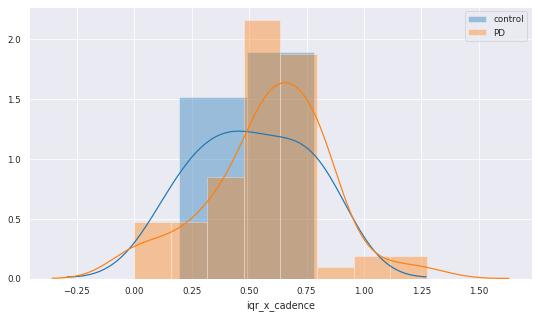

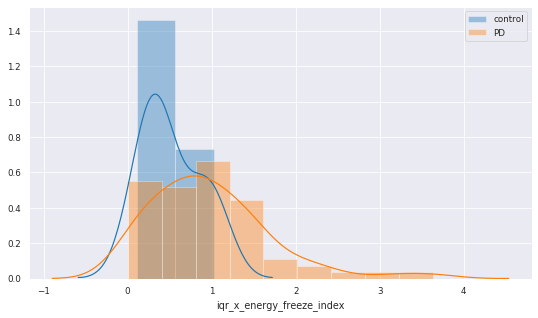

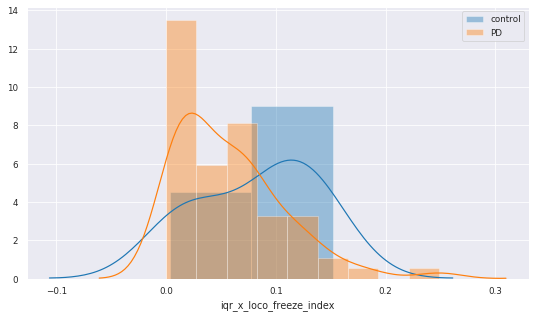

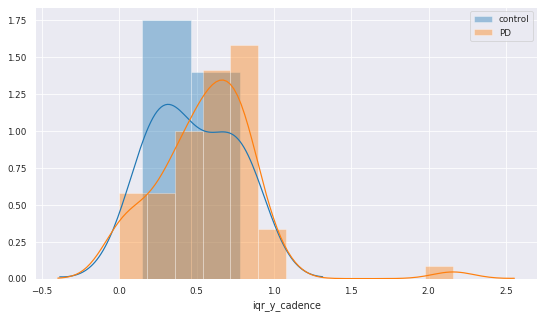

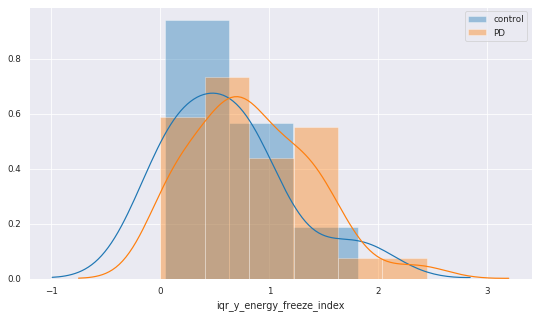

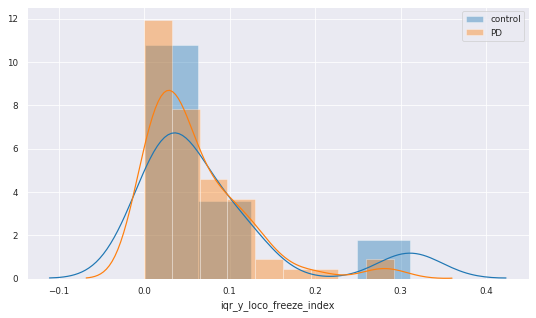

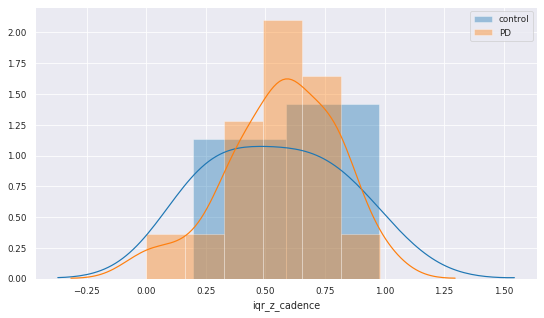

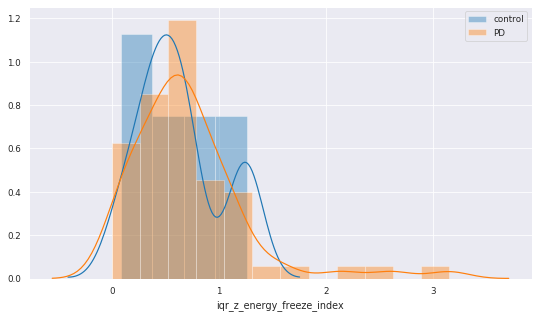

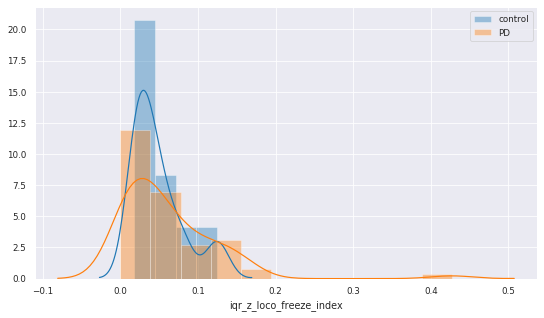

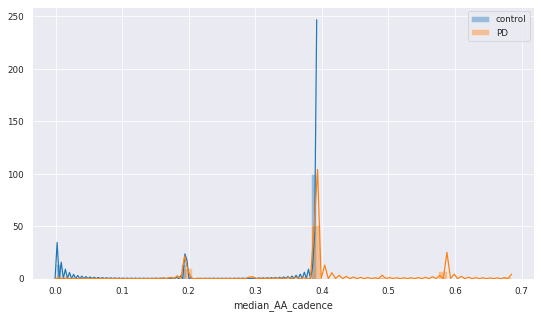

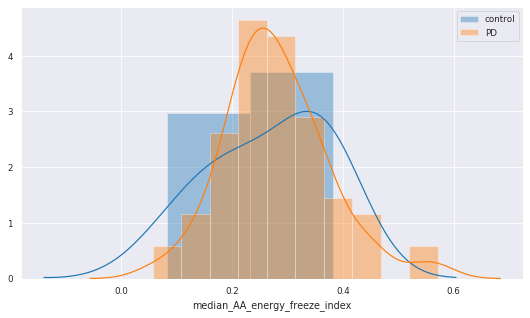

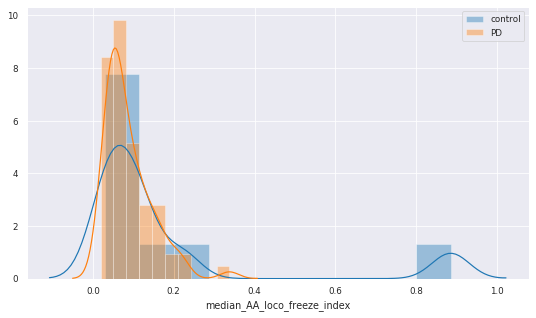

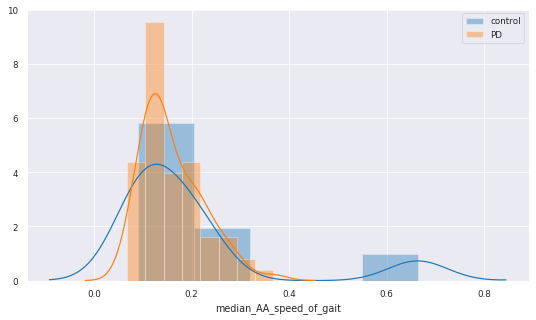

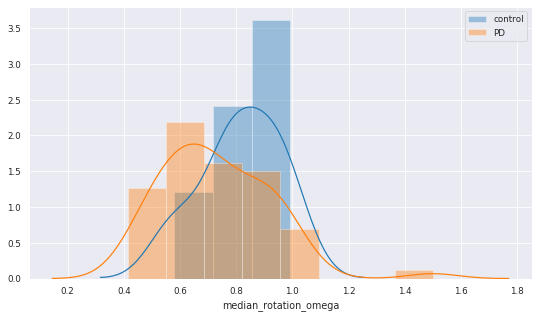

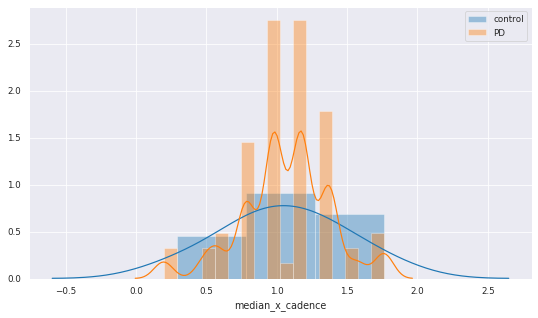

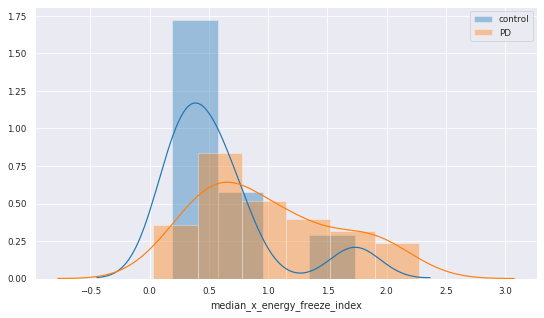

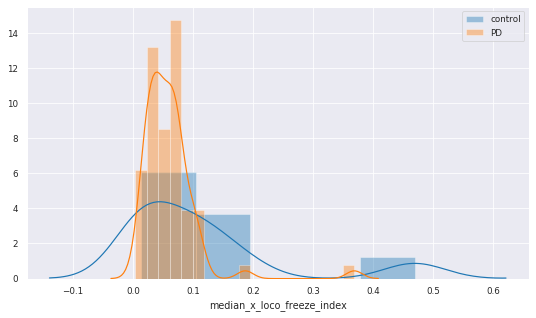

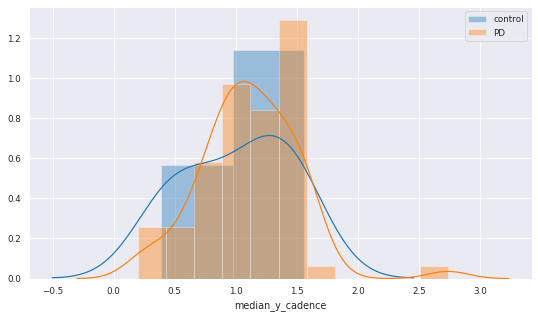

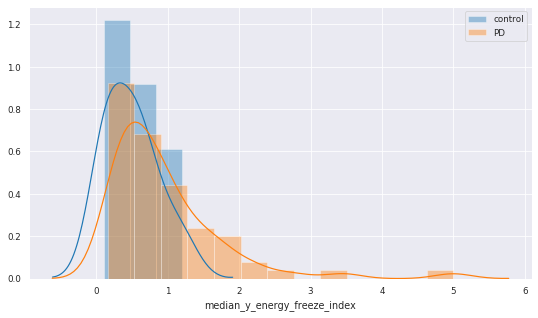

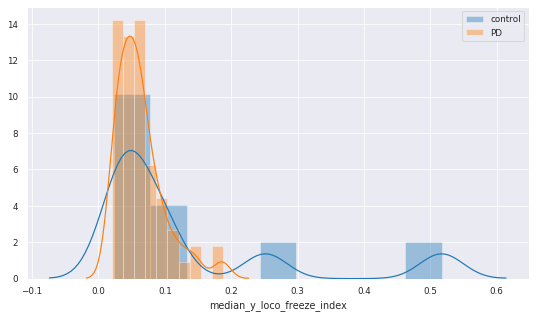

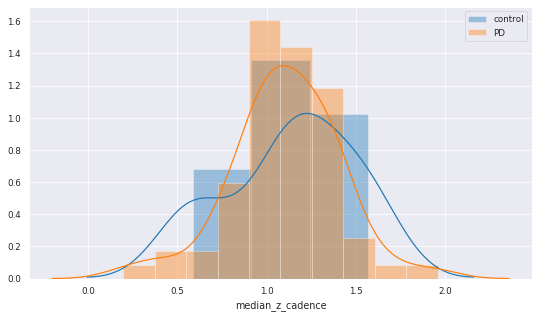

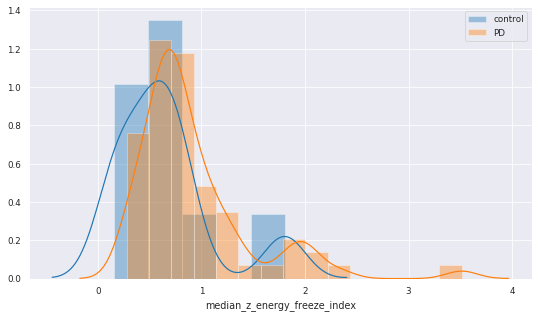

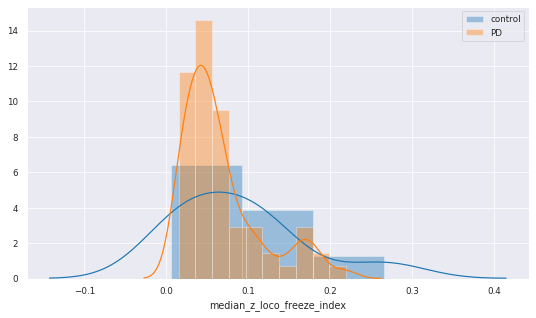

In [147]:
visualize_feature_in_classes(test_passive_set, feat_cols)